# Data cleaning and basic attempts

## Pre-set

In [1]:

import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline
from sklearn.cluster import KMeans

import xlsxwriter

In [2]:
df = pd.read_csv('opioid-addict.csv')
df = df[pd.notnull(df['news'])]

In [3]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-zA-Z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [4]:
def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    # text = BeautifulSoup(text, "lxml").text # HTML decoding
    # text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

## Data Cleaning

In [5]:
df['news_clean'] = df['news'].apply(clean_text)

In [6]:
document = list(df['news_clean'].apply(lambda x: x))

# Topic modeling

## KMeans++ clustering 

In [160]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(document)

In [53]:
true_k = 20
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=20, n_init=1, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [56]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

In [60]:
for i in range(true_k):
 print("Cluster %d:" % i),
 for ind in order_centroids[i, :10]:
     print(' %s' % terms[ind])

Cluster 0:
 games
 gaming
 game
 tencent
 video
 244why
 china
 addiction
 break
 chinese
Cluster 1:
 pain
 patients
 opioids
 opioid
 doctors
 chronic
 medical
 said
 prescription
 patient
Cluster 2:
 like
 people
 said
 im
 think
 time
 know
 life
 dont
 really
Cluster 3:
 health
 medicaid
 care
 insurance
 treatment
 said
 states
 state
 mental
 services
Cluster 4:
 los
 angeles
 la
 que
 en
 el
 las
 dodgers
 para
 times
Cluster 5:
 healthnew
 sues
 fueled
 maker
 oxycontin
 crisis
 jersey
 opioid
 opioidshow
 blowing
Cluster 6:
 spending
 budget
 democrats
 senate
 house
 shutdown
 billion
 government
 funding
 trump
Cluster 7:
 trump
 president
 said
 trumps
 house
 white
 donald
 republican
 democrats
 mr
Cluster 8:
 said
 new
 pm
 people
 like
 years
 percent
 addiction
 time
 state
Cluster 9:
 said
 police
 county
 court
 drug
 prison
 state
 gun
 judge
 attorney
Cluster 10:
 homeless
 housing
 people
 homelessness
 city
 said
 san
 shelter
 county
 streets
Cluster 11:
 opioid

## Stanford-NER location infor mining

In [7]:
import stanfordnlp
nlp = stanfordnlp.Pipeline(processors = "tokenize,mwt,lemma,pos")

Use device: cpu
---
Loading: tokenize
With settings: 
{'model_path': '/Users/fangzhouhu/stanfordnlp_resources/en_ewt_models/en_ewt_tokenizer.pt', 'lang': 'en', 'shorthand': 'en_ewt', 'mode': 'predict'}
---
Loading: lemma
With settings: 
{'model_path': '/Users/fangzhouhu/stanfordnlp_resources/en_ewt_models/en_ewt_lemmatizer.pt', 'lang': 'en', 'shorthand': 'en_ewt', 'mode': 'predict'}
Building an attentional Seq2Seq model...
Using a Bi-LSTM encoder
Using soft attention for LSTM.
Finetune all embeddings.
[Running seq2seq lemmatizer with edit classifier]
---
Loading: pos
With settings: 
{'model_path': '/Users/fangzhouhu/stanfordnlp_resources/en_ewt_models/en_ewt_tagger.pt', 'pretrain_path': '/Users/fangzhouhu/stanfordnlp_resources/en_ewt_models/en_ewt.pretrain.pt', 'lang': 'en', 'shorthand': 'en_ewt', 'mode': 'predict'}
Done loading processors!
---


In [9]:
pos_dict = {
'CC': 'coordinating conjunction','CD': 'cardinal digit','DT': 'determiner',
'EX': 'existential there (like: \"there is\" ... think of it like \"there exists\")',
'FW': 'foreign word','IN':  'preposition/subordinating conjunction','JJ': 'adjective \'big\'',
'JJR': 'adjective, comparative \'bigger\'','JJS': 'adjective, superlative \'biggest\'',
'LS': 'list marker 1)','MD': 'modal could, will','NN': 'noun, singular \'desk\'',
'NNS': 'noun plural \'desks\'','NNP': 'proper noun, singular \'Harrison\'',
'NNPS': 'proper noun, plural \'Americans\'','PDT': 'predeterminer \'all the kids\'',
'POS': 'possessive ending parent\'s','PRP': 'personal pronoun I, he, she',
'PRP$': 'possessive pronoun my, his, hers','RB': 'adverb very, silently,',
'RBR': 'adverb, comparative better','RBS': 'adverb, superlative best',
'RP': 'particle give up','TO': 'to go \'to\' the store.','UH': 'interjection errrrrrrrm',
'VB': 'verb, base form take','VBD': 'verb, past tense took',
'VBG': 'verb, gerund/present participle taking','VBN': 'verb, past participle taken',
'VBP': 'verb, sing. present, non-3d take','VBZ': 'verb, 3rd person sing. present takes',
'WDT': 'wh-determiner which','WP': 'wh-pronoun who, what','WP$': 'possessive wh-pronoun whose',
'WRB': 'wh-abverb where, when','QF' : 'quantifier, bahut, thoda, kam (Hindi)','VM' : 'main verb',
'PSP' : 'postposition, common in indian langs','DEM' : 'demonstrative, common in indian langs'
}

#extract parts of speech
def extract_pos(doc):
    parsed_text = {'word':[], 'pos':[], 'exp':[]}
    for sent in doc.sentences:
        for wrd in sent.words:
            if wrd.pos in pos_dict.keys():
                pos_exp = pos_dict[wrd.pos]
            else:
                pos_exp = 'NA'
            parsed_text['word'].append(wrd.text)
            parsed_text['pos'].append(wrd.pos)
            parsed_text['exp'].append(pos_exp)
    #return a dataframe of pos and text
    return pd.DataFrame(parsed_text)

#extract pos

df_out = extract_pos(doc)

NameError: name 'doc' is not defined

In [10]:
# A helper function to concate neighber location terms together
def combined_location(row):
    text = row["news"]
    tokenized_text = word_tokenize(text)
    classified_text = st.tag(tokenized_text)
    location = list(filter(lambda x : x[1][1] == 'LOCATION', enumerate(classified_text)))
    location = map(lambda x : (x[0],x[1][0]) , location)
    l = list(location)

    output = list()
    l.sort(key = lambda x: x[0])
    temp = ""
    prevIndex = ""
    for item in l:
        if temp == "":
            temp = item[1] 
            prevIndex = item[0]
            continue
        if prevIndex == item[0] - 1:
            temp = temp + " " + item[1]
            prevIndex = item[0]
        else:
            output.append(temp)
            temp = ""
    row['location'] = "{"+", ".join(list(set(output)))+"}"
    return row

In [11]:
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize

st = StanfordNERTagger('./stanford-ner/classifiers/english.all.3class.distsim.crf.ser.gz',
					   './stanford-ner/stanford-ner.jar',
					   encoding='utf-8')

df_sample_1000 = df.sample(n=1000, random_state=123)
df_sample_1000['location'] = None
df_sample_1000 = df_sample_1000.apply(combined_location,axis=1)
#for index, row in df_sample_1000.iterrows():
    
    

KeyboardInterrupt: 

In [62]:
df.to_excel('data_clean_with_topic_10.xlsx', engine='xlsxwriter')

/usr/local/lib/python3.7/site-packages/xlsxwriter/worksheet.py:937: UserWarning: Ignoring URL 'https://youtu.be/E5lEM03hpj4

VIDEO:%20Listen%20to%20some%20of%20the%20chatter%20from%20San%20Francisco%20police%20communications%20on%20the%20Aldon%20Smith%20incident.

CLICK%20HERE%20if%20you’re%20having%20trouble%20viewing%20the%20gallery%20on%20your%20mobile%20device.

Former%20Raiders%20linebacker%20Aldon%20Smith%20has%20turned%20himself%20in%20to%20San%20Francisco%20Police,%20who%20had%20a%20warrant%20out%20for%20his%20arrest%20over%20a%20domestic%20violence%20incident%20with%20his%20fiancee%20over%20the%20weekend.

ABC%207%20News,%20citing%20unnamed%20sources,%20was%20the%20first%20to%20report%20that%20Smith%20had%20turned%20himself%20in.%20Smith,%20who%20had%20reportedly%20checked%20himself%20into%20a%20rehabilitation%20facility,%20was%20released%20by%20the%20Raiders%20on%20Monday%20afternoon.

Smith%20was%20then%20released%20on%20$30,000%20bail%20late%20Tuesday%20afternoon.

Smith,%2

/usr/local/lib/python3.7/site-packages/xlsxwriter/worksheet.py:945: UserWarning: Ignoring URL 'http://www.newspress.com/Top/index.jsp' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  "65,530 URLS per worksheet." % force_unicode(url))


In [192]:
df_sample_1000.to_excel('1000_sample_location_included.xlsx', engine='xlsxwriter')

In [193]:
df_sample_1000.head(1)

,news,id,collectiondate,title,url,publishdate,author,keywords,src,title_news_tsv,language,news_clean,location
5458,With a new ABC talk show and his return to `Sa...,3374053,2018-11-01,The Complicated Politics of Alec Baldwin,https://www.hollywoodreporter.com/features/ale...,2018-11-01,{Lacey Rose},"{going,youre,politics,trump,complicated,baldwi...",https://www.theatlantic.com/news/,NaN,NaN,With new ABC talk show return Saturday Night L...,"{New York, Norway, Hollywood, Long Island, Ire..."


## LDA topic modeling

Following the tutorial : <a href = "https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0"> link </a>

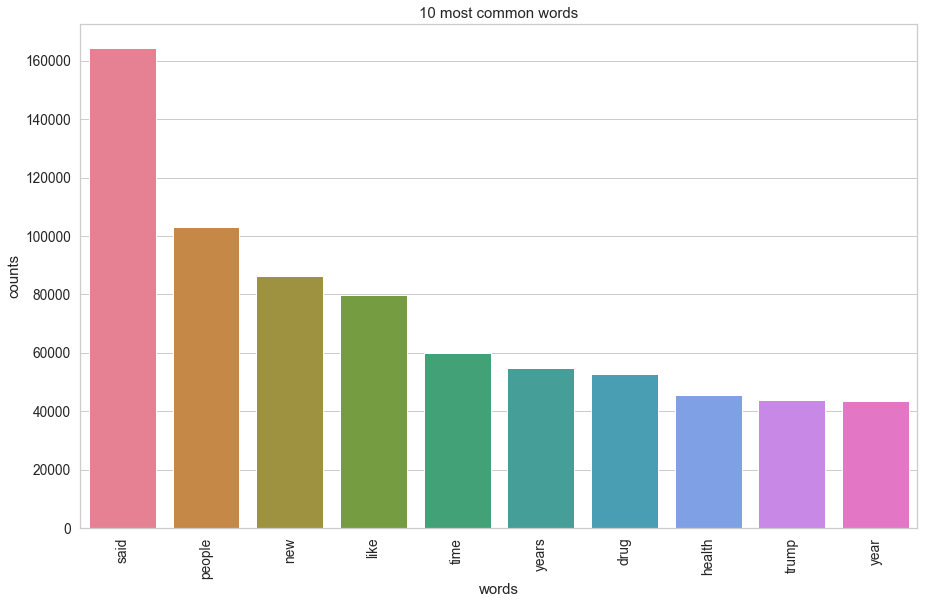

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
temp_df = df
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(temp_df['news_clean'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [21]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 10
number_words = 15
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
food like coffee restaurant new chicken sugar best make good eat day chef water bar

Topic #1:
said photo house spending budget border 2018 government orange scng billion trump democrats immigration senate

Topic #2:
people like time said use think dont new facebook social thats make way know research

Topic #3:
like life story time times world new book people way said los angeles years family

Topic #4:
new star click instagram actress dress black look getty showed ap photos like left stars

Topic #5:
trump said president people new state white house health states percent government trumps tax years

Topic #6:
like said know im mr think people time dont la going thats really told got

Topic #7:
pm game games new company google apple app free players video million year st chico

Topic #8:
said people treatment years health addiction homeless county says care help like time family children

Topic #9:
said drug opioid drugs state marijuana police medical 

In [22]:
print_topics(lda, count_vectorizer, 20)


Topic #0:
food like coffee restaurant new chicken sugar best make good eat day chef water bar years eating cheese little kitchen

Topic #1:
said photo house spending budget border 2018 government orange scng billion trump democrats immigration senate deal president shutdown county beach

Topic #2:
people like time said use think dont new facebook social thats make way know research youre really says study things

Topic #3:
like life story time times world new book people way said los angeles years family love know good school best

Topic #4:
new star click instagram actress dress black look getty showed ap photos like left stars angeles film los music red

Topic #5:
trump said president people new state white house health states percent government trumps tax years year american political republican like

Topic #6:
like said know im mr think people time dont la going thats really told got hes weinstein didnt new says

Topic #7:
pm game games new company google apple app free players vi

In [52]:
matrix = lda.transform(count_data)

In [56]:
df["topic"] = range(38509)
# 
print_some = 5

for index, x in enumerate(matrix):
    df["topic"][index] = x.argmax(axis=0) 
    if index % 100 == 0 :
        print(index, x.argmax(axis=0))
    if x.argmax(axis=0) == 9 and print_some >= 0:
        print(print_some, df["url"][index])
        print_some = print_some - 1

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0 2
5 https://www.cleveland.com/westlake/index.ssf/2019/02/officers_investigate_home_burg.html
4 http://www.sandiegouniontribune.com/news/sns-bc-fbn--kraft-goodells-powers-20190223-story.html#nt=oft11aH-3li2
3 https://www.mercurynews.com/2019/02/22/gilroy-officers-cleared-video-released-in-controversial-arrest-death-of-stevie-juarez/
2 http://www.ocregister.com/2019/02/21/dea-makes-southern-california-arrests-in-operation-hypocritical-oath-drug-probe/
1 https://www.dallasnews.com/news/crime/2019/02/22/suspended-cleburne-doctor-jailed-charges-molested-young-patients
0 https://www.natlawreview.com/article/insurance-coverage-defendants-named-nationwide-opioid-litigation
100 4
200 2
300 4
400 3
500 5
600 0
700 2
800 8
900 3
1000 5
1100 2
1200 9
1300 7
1400 9
1500 2
1600 2
1700 7
1800 8
1900 5
2000 2
2100 9
2200 9
2300 8
2400 9
2500 9
2600 2
2700 8
2800 8
2900 5
3000 8
3100 9
3200 5
3300 2
3400 5
3500 4
3600 7
3700 7
3800 9
3900 7
4000 7
4100 1
4200 3
4300 9
4400 2
4500 9
4600 2
4700 8
4800

In [61]:
df.head(1)


,news,id,collectiondate,title,url,publishdate,author,keywords,src,title_news_tsv,language,news_clean,topic
0,"Juul, a Silicon Valley e-cigarette startup wit...",4079443,2019-02-24,E-cigarette company Juul is now doing health r...,https://www.businessinsider.com/juul-e-cig-mar...,2019-02-24,{Erin Brodwin},"{ecigarettes,health,biomarkers,juul,company,ec...",http://www.businessinsider.com,NaN,NaN,Juul Silicon Valley ecigarette startup reputat...,2


## word cloud

     |████████████████████████████████| 163kB 3.8MB/s eta 0:00:01
     |████████████████████████████████| 3.9MB 2.3MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


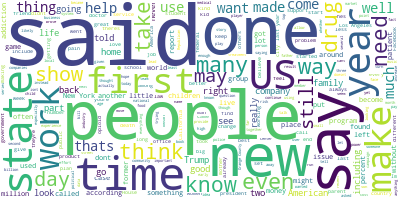

In [13]:
!pip3 install wordCloud

from wordcloud import WordCloud
# change dataframe
temp_df = df_sample_1000
long_string = ','.join(list(temp_df['news_clean'].values))

wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()